In [1]:
%pylab inline
import scipy.stats as sps
import scipy.integrate as spi
import seaborn as sns
import csv

import dask
from dask.distributed import Client

import time

from dask_jobqueue import SLURMCluster

sns.set_context('talk')

Populating the interactive namespace from numpy and matplotlib


/home/lag36/anaconda3/lib/python3.7/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
run_local = False
n_workers_init = 6

if run_local:
    client = Client()
    client.cluster.scale(n_workers_init)
    time.sleep(0.5) # allow client time to respond to scaling before display
else:
    # note the specifed walltime, don't use too much or too little, 01:30:00 is a good baseline, 
    # you just need enough time to finish 'gathering' to props_all before the jobs die
    # you can always spin up more jobs later
    # you will launch many jobs, so you don't need multiple processes, a lot of ram or multiple threads
#     cluster = SLURMCluster(queue="short",walltime='01:30:00',job_cpu=1,job_mem='6G',threads=1,processes=1,memory='6GB')
    
    #SHORT RUNS
#     cluster = SLURMCluster(queue="short",walltime='01:30:00',job_cpu=1,job_mem='6G',cores=1,processes=1,memory='6G')
    cluster = SLURMCluster(queue="short",walltime='01:30:00',job_cpu=1,job_mem='6G',cores=1,processes=1,memory='6G')
    cluster.start_workers(n_workers_init)
    client = Client(cluster)

client

Client Scheduler: tcp://10.120.16.51:42226 Dashboard: http://10.120.16.51:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [7]:
def plot_heatmap(MTs, STs, MN, mTa, MTs_step, exp_key = None):
    
    #Indices of E(T_s) values for max fitness as a function of std
    max_MTs_vs_std = np.argmax(MN, axis=0)
    #Indices of std(T_s) values for max fitness as a function of E(T_s)
    max_STs_vs_mean = np.argmax(MN, axis=1)

    plt.figure(figsize=(8,5))
    y_conv = np.arange(len(max_MTs_vs_std))
    plt.plot(max_MTs_vs_std+0.5, y_conv+0.5, '--')
    x_conv = np.arange(len(max_STs_vs_mean))
    plt.plot(x_conv+0.5, max_STs_vs_mean+0.5, '--')
    # ax = sns.heatmap(MN.T/n0, yticklabels=STs, xticklabels=MTs)
    ax = sns.heatmap(MN.T, yticklabels=False, xticklabels=False)
#     plt.locator_params(nbins = 5, tight=)
    plt.vlines(np.where(abs(MTs-mTa) <= MTs_step/2)[0][0]+0.5, 0,len(y_conv), color='r', linestyles='--')
    ax.invert_yaxis()
    plt.ylabel('Standard deviation')
    plt.xlabel('Mean lag time')
    plt.title('$t_a=$'+str(mTa))
    if exp_key:
        plt.savefig('./exp_'+exp_key+'_hmap.png')
        

In [3]:
plot_heatmap(MTs, STs, NN, mTa, MTs_step, exp_key=exp_key)
plot_max_lines(MTs, STs, NN, mTa, exp_key=exp_key)

NameError: name 'plot_heatmap' is not defined

In [31]:
def plot_max_lines(MTs, STs, MN, mTa, exp_key = None):
    #Indices of E(T_s) values for max fitness as a function of std
    max_MTs_vs_std = np.argmax(MN, axis=0)
    #Indices of std(T_s) values for max fitness as a function of E(T_s)
    max_STs_vs_mean = np.argmax(MN, axis=1)
    
    fig, axs = plt.subplots(1,2, figsize=(7,3.5), tight_layout=True)

    axs[0].plot(STs, MTs[max_MTs_vs_std], 'o-')
    axs[0].set_xlabel('$\sigma(T_s)$')
    axs[0].set_ylabel('$E(T_s)$ for max. fitness')

    axs[1].plot(MTs, [STs[e] for e in max_STs_vs_mean], 'o-')
    axs[1].set_xlabel('$E(T_s)$')
    axs[1].set_ylabel('$\sigma(T_s)$ for max. fitness')
    
    if exp_key:
        plt.savefig('./exp_'+exp_key+'_maxs.png')
    
def save_experiment(exp_key, res, kwargs, kwargs_s):

    # Save NN
    np.save('./iexp_'+exp_key, res)
    # Save metadata (parameters)
    file = open('./iexp_'+exp_key+'_meta.csv', "w")
    w = csv.writer(file)
    for key, val in kwargs.items():
        w.writerow([key, val])
    for key, val in kwargs_s.items():
        w.writerow([key, val])
    file.close()
    
def load_metadata(exp_key, prefix = './', print_meta = True):
    '''
    Loads the metadata, which contains all the parameters used for the simulation
    BE CAREFUL: The parameters are set as global variables!!
    If print_meta == True, it prints the values of the imported parameters
    '''
    
    infile =open(prefix+'iexp_'+exp_key+'_meta.csv', mode='r')
    reader = csv.reader(infile)
    meta = list(reader)
    infile.close()
    
    global mTa, sTa, tg, MTs_start, MTs_stop, MTs_step, STs_start, STs_stop, STs_step
    
    mTa = float(meta[0][1])
    sTa = float(meta[1][1])
    tg = float(meta[2][1])
    MTs_start = float(meta[3][1])
    MTs_stop = float(meta[4][1])
    MTs_step = float(meta[5][1])
    STs_start = float(meta[6][1])
    STs_stop = float(meta[7][1])
    STs_step = float(meta[8][1])
    if print_meta:
        print(meta)
    
    return meta

def integrand_1(s, Ts):
    return np.exp(-s)*Ts.pdf(s)

def integral_1(ta, t, Ts):
    return spi.quad(integrand_1, ta, t, args=(Ts))[0]

def mN_det_Ta(mTa, t, Ts):
    # OJO: Only when t > ta
    return np.exp(t)*integral_1(mTa, t, Ts) + 1 - Ts.cdf(t)

def integrand_2(ta, t, Ta, Ts):
    return Ta.pdf(ta)*integral_1(ta, t, Ts)

def integral_2(t, Ta, Ts):
    return spi.quad(integrand_2, 0, t, args=(t, Ta, Ts))[0]

def mN_stoch_Ta(t, Ta, Ts):
    return np.exp(t)*integral_2(t, Ta, Ts)+1-Ts.cdf(t)

def run_deterministic_one(mTs, sTs, mTa, sTa=0, tg=8):
    Ts = sps.norm(mTs, sTs)
    return mN_det_Ta(mTa, tg, Ts)

def run_deterministic_single_sTs(sTs, MTs, mTa, sTa, tg=8):
    N = np.zeros(len(MTs))
    for i in range(len(MTs)):
        mTs = MTs[i]
        N[i] = run_deterministic_one(mTs, sTs, mTa, sTa=0, tg=8)
    return N

def run_deterministic(MTs, STs, mTa, sTa=0, tg=8):
    
    NN = np.zeros((len(MTs), len(STs)))
    
    for i in range(len(MTs)):
        mTs = MTs[i]
        for j in range(len(STs)):
            sTs = STs[j]
            
            NN[i,j] = run_deterministic_one(mTs, sTs, mTa, sTa=0, tg=tg)
#             Ts = sps.norm(mTs, sTs)
#             NN[i,j] = mN_det_Ta(mTa, tg, Ts)
    return NN

def run_stochastic_one(mTs, sTs, mTa, sTa, tg):
    Ts = sps.norm(mTs, sTs)
    Ta = sps.norm(mTa, sTa)
    return mN_stoch_Ta(tg, Ta, Ts)

def run_stochastic_single_sTs(sTs, MTs, mTa, sTa, tg):
    N = np.zeros(len(MTs))
    for i in range(len(MTs)):
        mTs = MTs[i]
        N[i] = run_stochastic_one(mTs, sTs, mTa, sTa, tg=8)
    return N

def run_stochastic(MTs, STs, Ta, tg):
    
    NN = np.zeros((len(MTs), len(STs)))
    
    for i in range(len(MTs)):
        mTs = MTs[i]
        for j in range(len(STs)):
            sTs = STs[j]
            Ts = sps.norm(mTs, sTs)
            NN[i,j] = mN_stoch_Ta(tg, Ta, Ts)
    return NN



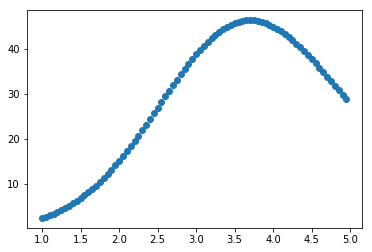

In [6]:
mTa = 3
tg = 8
sTa =0
sTs = 1
MTs = np.arange(1,5,0.05)

Ng = np.zeros(shape(MTs))

for i in range(len(MTs)):
    mTs = MTs[i]
    Ng[i] = run_deterministic_one(mTs, sTs, mTa, sTa, tg)
    
plt.plot(MTs,Ng, 'o')

### I have to
- Validate that the stochastic version is right (compare with the sampling method)
- Screen the deterministic version for different 

- There seems to be a result! If everything else is the same, the fitness can be larger when the std of the antibiotic duration is larger!

In [55]:
mTa = 3
sTa = 1.5 # deterministic Ta
tg = 8

MTs_start = 1
MTs_stop = 8
MTs_step = 0.05

STs_start = 0.05
STs_stop = 2
STs_step = 0.05

kwargs_s = {'MTs_start':MTs_start, 'MTs_stop':MTs_stop, 'MTs_step':MTs_step,
            'STs_start':STs_start, 'STs_stop':STs_stop, 'STs_step':STs_step}

MTs = np.arange(MTs_start, MTs_stop, MTs_step)
STs = np.arange(STs_start, STs_stop, STs_step)

kwargs = {'mTa':mTa, 'sTa':sTa, 'tg':tg}

exp_key = '008'

# NN = run_deterministic(MTs, STs, mTa, sTa=0, tg=8)
# Ta = sps.norm(mTa, sTa)
# NN = run_stochastic(MTs, STs, Ta, tg=8)
# save_experiment(exp_key, NN, kwargs, kwargs_s)

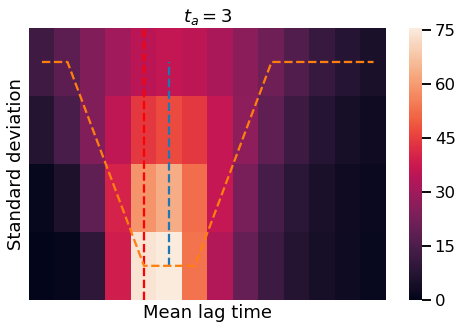

In [30]:
plot_heatmap(MTs, STs, NN, mTa, MTs_step)

## Cluster!

In [25]:
scale_workers = 0

if scale_workers > 0:
    cluster.scale(scale_workers)

def PAR_run_deterministic_single_sTs(sTs):
    return run_deterministic_single_sTs(sTs, MTs, **kwargs)
    
fut = client.map(PAR_run_deterministic_single_sTs, STs)
# dask.distributed.progress(fut)
res = np.array(client.gather(fut)).T
exp_key = '005' # MODIFY SO YOU DON'T OVERWRITE!!!!!
save_experiment(exp_key, res, kwargs, kwargs_s)

In [48]:
client.restart()

Client Scheduler: tcp://127.0.0.1:45651 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 6 Memory: 24.82 GB


In [56]:
scale_workers = 50
if scale_workers > 0:
    cluster.scale(scale_workers)

futures = []
for sTs in STs:
    def PAR_run_stoch_one(mTs):
        return run_stochastic_one(mTs, sTs, **kwargs)
    fut = client.map(PAR_run_stoch_one, MTs)
    futures.append(fut)
all_futures = [fu for sublist in futures for fu in sublist]
dask.distributed.progress(all_futures)

VBox()

In [57]:
res = np.array(client.gather(futures)).T
exp_key = '010' # MODIFY SO YOU DON'T OVERWRITE!!!!!
save_experiment(exp_key, res, kwargs, kwargs_s)

In [53]:
shape(res)

(140, 39)

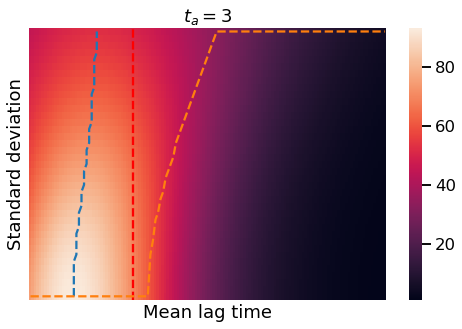

/home/lag36/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


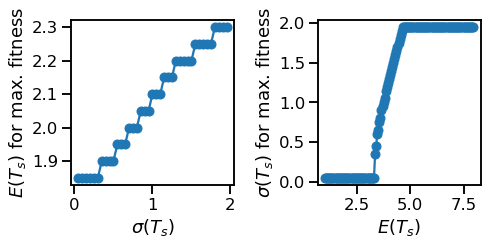

In [58]:
plot_heatmap(MTs, STs, res, mTa, MTs_step, exp_key = exp_key)
plot_max_lines(MTs, STs, res, mTa, exp_key = exp_key)

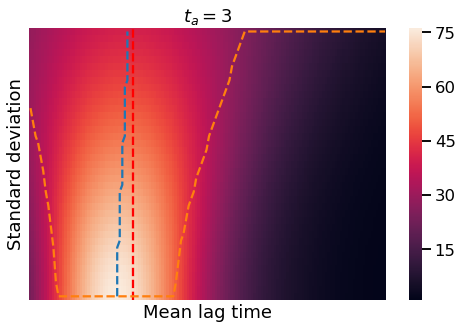

/home/lag36/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


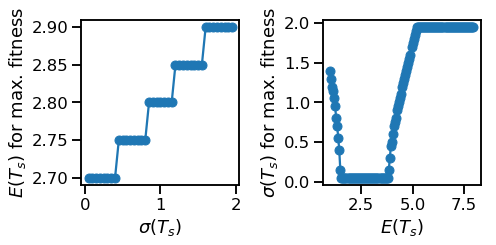

In [54]:
plot_heatmap(MTs, STs, res, mTa, MTs_step, exp_key = exp_key)
plot_max_lines(MTs, STs, res, mTa, exp_key = exp_key)

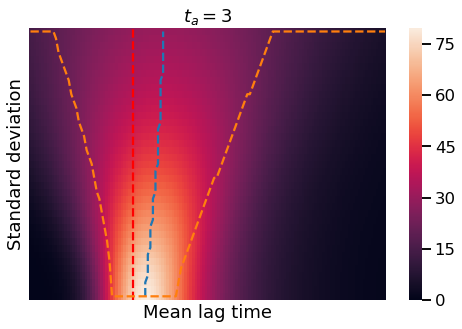

/home/lag36/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


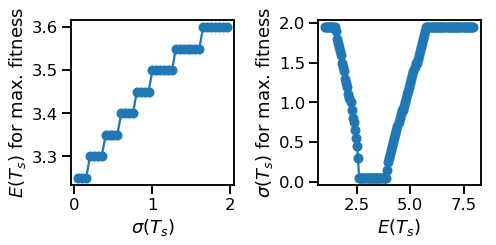

In [45]:
plot_heatmap(MTs, STs, res, mTa, MTs_step, exp_key = exp_key)
plot_max_lines(MTs, STs, res, mTa, exp_key = exp_key)

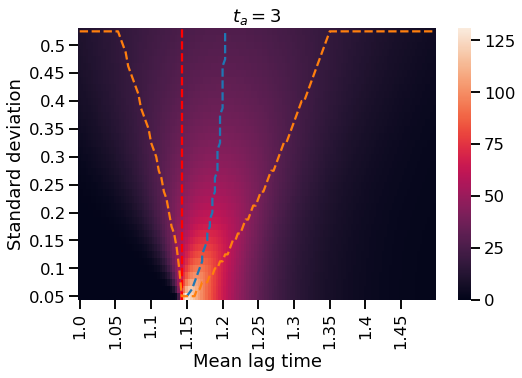

In [27]:
plot_heatmap(MTs, STs, NN, mTa, MTs_step, exp_key=exp_key)
# plot_max_lines(MTs, STs, NN, mTa)

## Load

In [54]:
prefix = './'

exp_key = '001'
meta = load_metadata(exp_key, prefix)
res = np.load(prefix+'iexp_'+exp_key+'.npy')

[['mTa', '3'], ['sTa', '0'], ['tg', '8'], ['MTs_start', '1'], ['MTs_stop', '8'], ['MTs_step', '0.25'], ['STs_start', '0.5'], ['STs_stop', '2'], ['STs_step', '0.25']]


In [9]:
mTa = 3
sTa = 0.5
Ta = sps.norm(mTa, sTa)

NN = run_stochastic(MTs, STs, Ta, tg)

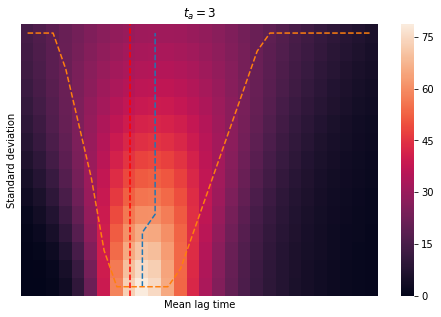

In [11]:
plot_heatmap(MTs, STs, NN, mTa)

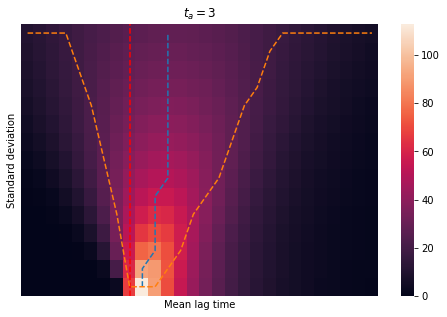

In [10]:
plot_heatmap(MTs, STs, res, mTa)

In [ ]:
scale_workers = 0

if scale_workers > 0:
    cluster.scale(scale_workers)

def PAR_run_deterministic_single_sTs(sTs):
    return run_deterministic_single_sTs(sTs, MTs, **kwargs)
    
fut = client.map(PAR_run_deterministic_single_sTs, STs)
# dask.distributed.progress(fut)
res = np.array(client.gather(fut)).T
exp_key = '002' # MODIFY SO YOU DON'T OVERWRITE!!!!!
save_experiment(exp_key, res, kwargs, kwargs_s)

In [55]:
def get_max_of_max(MTs, STs, MN):
    '''
    Get the numbers associated with the values of parameters that yield the maximum fitness.
    '''

    max_col_ind = np.argmax(np.max(MN, axis = 1))
    max_row_ind = np.argmax(np.max(MN, axis = 0))
    
#     max_MTs_vs_std = np.argmax(MN, axis=0)
#     plt.plot(STs, MTs[max_MTs_vs_std], '-o', label = str(sTa))
    
    mean_max_fit = MTs[max_col_ind] # Mean lag time that yields max fitness
    std_max_fit = STs[max_row_ind] # Std of lag times that yields max fitness
    
    max_fit = MN[max_col_ind, max_row_ind] # Final population that yields max fitness
#     max_fit_var = np.sqrt(VN[max_col_ind, max_row_ind]) # Variance in final population that yields max fitness

    return mean_max_fit, std_max_fit, max_fit

# get_max_of_max(MTs, STs, NN)

In [48]:
def max_several_exp_det(MTs, STs, MTa, tg):
    
    Mean_max_fit, Std_max_fit, Max_fit = np.zeros(len(MTa)), np.zeros(len(MTa)), np.zeros(len(MTa))    
    for i in range(len(MTa)):
        mTa = MTa[i]
        NN = run_deterministic(MTs, STs, mTa, tg) # REPLACE FOR LOAD LATER!
        Mean_max_fit[i], Std_max_fit[i], Max_fit[i] = get_max_of_max(MTs, STs, NN)
    return Mean_max_fit, Std_max_fit, Max_fit

In [49]:
MTs_start = 1
MTs_stop = 8
MTs_step = 0.25

STs_start = 0.05
STs_stop = 2
STs_step = 0.2

MTs = np.arange(MTs_start, MTs_stop, MTs_step)
STs = np.arange(STs_start, STs_stop, STs_step)

MTa_start = 2
MTa_stop = 5
MTa_step = 0.25
MTa = np.arange(MTa_start, MTa_stop, MTa_step)

Mean_max_fit, Std_max_fit, Max_fit = max_several_exp_det(MTs, STs, MTa, tg)

/home/gutiloluis/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


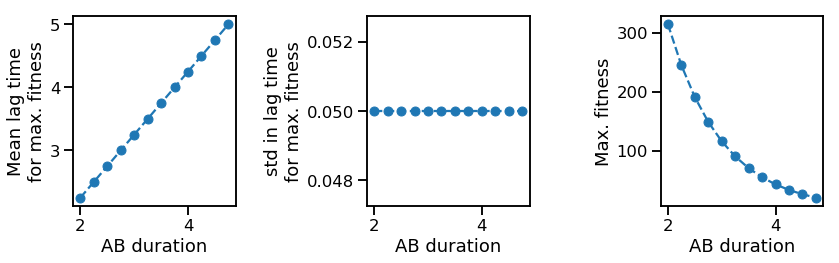

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(12,4),tight_layout=True)
ax[0].plot(MTa, Mean_max_fit, 'o--')
ax[0].set_xlabel('AB duration')
ax[0].set_ylabel('Mean lag time\nfor max. fitness')

ax[1].plot(MTa, Std_max_fit, 'o--')
ax[1].set_xlabel('AB duration')
ax[1].set_ylabel('std in lag time\nfor max. fitness')

ax[2].plot(MTa, Max_fit, 'o--')
ax[2].set_xlabel('AB duration')
ax[2].set_ylabel('Max. fitness')

plt.savefig('screening1.png')

In [ ]:
def max_several_exp_stoch(MTs, STs, MTa, tg):
    
    Mean_max_fit, Std_max_fit, Max_fit = np.zeros(len(MTa)), np.zeros(len(MTa)), np.zeros(len(MTa))    
    for i in range(len(MTa)):
        mTa = MTa[i]
        NN = run_deterministic(MTs, STs, mTa, tg) # REPLACE FOR LOAD LATER!
        Mean_max_fit[i], Std_max_fit[i], Max_fit[i] = get_max_of_max(MTs, STs, NN)
    return Mean_max_fit, Std_max_fit, Max_fit